In [129]:
!pip install scikit-learn==1.1.1 --user

     ---------------------------------------- 7.3/7.3 MB 67.0 MB/s eta 0:00:00


In [2]:
!pip install librosa

     ------------------------------------- 213.1/213.1 KB 12.7 MB/s eta 0:00:00
     ------------------------------------- 377.5/377.5 KB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 323.4/323.4 KB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 56.3/56.3 KB ? eta 0:00:00
     ------------------------------------- 689.4/689.4 KB 21.9 MB/s eta 0:00:00
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23154 sha256=b50567748bb8985a5c63988b823c0850716c3cf0ef40374e974c842a5c516525
  Stored in directory: c:\users\김태환\appdata\local\pip\cache\wheels\a2\a3\bd\ec1568ce7515115a11ab686d509ad302124c782af065de47ee
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320731 sha256=c3d68f0ef408df3f71849c9848dde823

You should consider upgrading via the 'D:\users\python.exe -m pip install --upgrade pip' command.


## Import

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa, librosa.display
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

## Hyperparameter Setting

In [5]:
CFG = {
    'SR':16000, # Sampling rate 음성 주파수 사람이 음성은 16000hz까지만 
    'N_MFCC':50, # MFCC 벡터를 추출할 개수 - 더 다양한 데이터의 특징을 추출하기위해선 증가
    'SEED': 50
}

In [6]:
 physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

## Fixed Random-Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-Processing 1

In [8]:
train_df = pd.read_csv('wav_dataset/train_data.csv')
test_df = pd.read_csv('wav_dataset/test_data.csv')
unlabeled_df = pd.read_csv('wav_dataset/unlabeled_data.csv')

# MFCC

In [9]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = './wav_dataset'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(e)
            #y_feature.append(np.std(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['std_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [ ]:
get_mfcc_feature(train_df, 'train', './train_mfcc50_e_data.csv')
get_mfcc_feature(test_df, 'test', './test_mfcc50_e_data.csv')
# get_mfcc_feature(unlabeled_df, 'unlabeled', './unlabeled_mfcc_data.csv')

  0%|          | 0/3805 [00:00<?, ?it/s]

# Melspectrogram

In [185]:
def get_melspectrogram(df, data_type, save_path):
    root_folder = './wav_dataset'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 melspectrogram 추출
        # n_fft = 2048
        # win_length = 2048
        # hop_length = 1024
        # n_mels = 128
        # D = np.abs(librosa.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length))
        # melspectrogram = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length = hop_length, win_length = win_length)
        melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=128)

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in melspectrogram:
            y_feature.append(np.mean(e))
        features.append(y_feature)
        
    mel_df = pd.DataFrame(features, columns=['mel_'+str(x) for x in range(1,128+1)])
    df = pd.concat([df, mel_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [186]:
get_melspectrogram(train_df, 'train', './train_melspec_data.csv')
get_melspectrogram(test_df, 'test', './test_melspec_data.csv')

  0%|          | 0/3805 [00:00<?, ?it/s]

Done.


  0%|          | 0/5732 [00:00<?, ?it/s]

Done.


# CENS

In [6]:
def get_chroma_cens(df, data_type, save_path):
    root_folder = './wav_dataset'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=32)

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in cens:
            y_feature.append(np.mean(e))
        features.append(y_feature)
        
    cens_df = pd.DataFrame(features, columns=['cens_'+str(x) for x in range(1,12+1)])
    df = pd.concat([df, cens_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [7]:
get_chroma_cens(train_df, 'train', './train_cens_data.csv')
get_chroma_cens(test_df, 'test', './test_cens_data.csv')

  0%|          | 0/3805 [00:00<?, ?it/s]

Done.


  0%|          | 0/5732 [00:00<?, ?it/s]

Done.


## Data Pre-Processing 2

In [112]:
# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
mfcc = pd.read_csv('./train_mfcc50_data.csv')
std = pd.read_csv('./train_mfcc50_std_data.csv')
mel = pd.read_csv('./train_melspec_data.csv')
cens = pd.read_csv('./train_cens_data.csv')

In [113]:
# gender 성별 other 제거 전처리
# other = train_df['gender'].isin(['other'])
# train_df = train_df[~other]
# train_df['gender'].unique()
# train_df = train_df.reset_index(drop=True)
# train_df

In [114]:
# mfcc + std feature merge
merge = pd.merge(mfcc, std)
train_df = merge
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,std_41,std_42,std_43,std_44,std_45,std_46,std_47,std_48,std_49,std_50
0,1,24,female,0,1,0,-274.93472,29.345425,-19.152718,-7.836880,...,3.940978,4.168008,3.704519,3.413724,2.929554,3.248392,3.697180,3.536256,3.146748,2.808870
1,2,51,male,0,0,0,-311.56317,52.478150,-0.098956,-11.070889,...,2.902553,3.375166,2.895491,3.463745,2.674759,3.713707,2.245376,3.168638,2.803887,2.966493
2,3,22,male,0,0,0,-438.29000,46.588910,-22.689060,-3.607528,...,2.923307,2.826745,2.836245,3.008061,4.059071,2.986710,2.961419,2.294150,2.040008,2.326215
3,4,29,female,1,0,0,-368.42612,46.939358,-7.443123,-3.694383,...,3.089176,3.700883,2.960053,3.161702,3.135634,3.220121,3.039690,3.141579,2.571923,2.961397
4,5,23,male,0,0,0,-535.19446,7.165523,-7.422007,2.231186,...,1.806763,2.371473,1.541948,2.607864,1.428324,2.125716,1.746210,1.723021,1.656174,2.108295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,3801,53,male,0,0,0,-328.48767,68.190380,-40.383747,2.297682,...,6.964136,9.271381,9.152610,11.020420,7.013804,7.292320,5.920861,6.238069,4.616245,4.588425
3801,3802,25,male,0,0,0,-386.25732,73.931350,-12.114974,-0.500644,...,4.896223,4.390753,5.094110,5.288200,6.331296,8.516347,7.311387,5.686339,4.536681,5.272469
3802,3803,26,female,0,0,0,-347.20593,58.544130,12.969809,27.973340,...,3.594398,2.927548,2.842786,3.129517,3.209869,2.796238,2.546851,3.392260,2.859212,2.692866
3803,3804,27,female,0,0,0,-179.11195,70.697860,-14.571251,-10.143574,...,4.868105,4.600739,4.650938,3.927352,4.996378,4.030235,4.039797,4.363599,5.360180,4.493088


In [115]:
# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
x_train = train_df.drop(columns=['id', 'covid19'])
y_train = train_df['covid19']

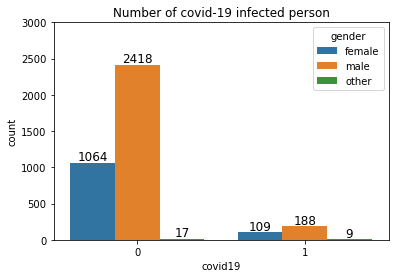

In [116]:
ax = sns.countplot(x='covid19', data = train_df, hue='gender')
plt.title('Number of covid-19 infected person')

# countplot에 값 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 12)
ax.set_ylim(0, 3000)
plt.show()

In [117]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded.astype('int'), columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [118]:
# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(x_train['gender'].values.reshape(-1,1))
x_train = onehot_encoding(ohe, x_train)

In [119]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [120]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(3044, 106)
(761, 106)
(3044,)
(761,)


# MLPclassifier

In [121]:
# mlp = MLPClassifier(random_state=CFG['SEED'],max_iter=1000,early_stopping=True, validation_fraction=0.1)
# mlp.fit(x_train, y_train)

## MLP Classifier

In [122]:
mlp = MLPClassifier(random_state=CFG['SEED'],max_iter=1000)
# # Sklearn에서 제공하는 Multi-layer Perceptron classifier 사용

mlp.fit(x_train, y_train) # Model Train

MLPClassifier(max_iter=1000, random_state=50)

## GridSerach CrossValidation

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

parameter_space = {
    'hidden_layer_sizes': [(13,10,5),(10,7,3),(30,20,10)],
    'activation': ['identity', 'logistic', 'softmax', 'tanh'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'batch_size' : [8,16,32]
}

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
clf = GridSearchCV(mlp, parameter_space, cv=cv, n_jobs=-1,verbose=2)
clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [124]:
# Best Parameters
print('Best parameters found:\n', clf.best_params_)
print('\nBest model found:\n', clf.best_estimator_)
print('\nBest score found:\n', clf.best_score_)

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 16, 'hidden_layer_sizes': (13, 10, 5), 'learning_rate': 'constant', 'solver': 'sgd'}

Best model found:
 MLPClassifier(activation='logistic', batch_size=16,
              hidden_layer_sizes=(13, 10, 5), max_iter=1000, random_state=50,
              solver='sgd')

Best score found:
 0.9211563391236712


In [125]:
clf = clf.best_estimator_

In [126]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(x_val)
print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.91


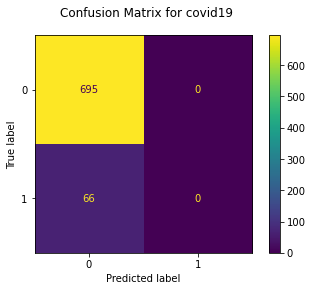

In [127]:
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(clf, x_val, y_val, display_labels=clf.classes_)
fig.figure_.suptitle("Confusion Matrix for covid19")
plt.show()

In [128]:
from sklearn.metrics import classification_report 
print('검증 세트에 대한 결과:') 
print(classification_report(y_val, y_pred))

검증 세트에 대한 결과:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       695
           1       0.00      0.00      0.00        66

    accuracy                           0.91       761
   macro avg       0.46      0.50      0.48       761
weighted avg       0.83      0.91      0.87       761



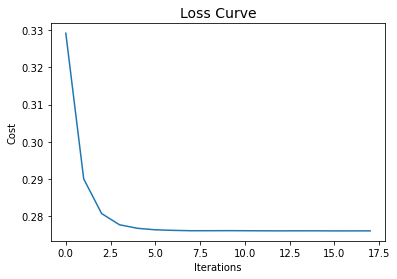

In [129]:
plt.plot(clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## Inference

In [130]:
# 위의 학습데이터를 전처리한 과정과 동일하게 test data에도 적용
test_mfcc = pd.read_csv('./test_mfcc50_data.csv')
test_std = pd.read_csv('./test_mfcc50_std_data.csv')
test_mel = pd.read_csv('./test_melspec_data.csv')
test_cens = pd.read_csv('./test_cens_data.csv')

# mfcc + std feature merge
merge_test = pd.merge(test_mfcc, test_std)

test_df = merge_test
test_df = test_df.drop(columns=['id'])

# Data Leakage에 유의하여 train data로만 학습된 ohe를 사용
test_df = onehot_encoding(ohe, test_df)

# # Model 추론
preds = clf.predict(test_df)

## Submission

In [131]:
submission = pd.read_csv('wav_dataset/sample_submission.csv',encoding = 'utf8')
submission['covid19'] = preds
submission.to_csv('./submit_0623_mlp', index=False)

In [132]:
submission

,id,covid19
0,3806,0
1,3807,0
2,3808,0
3,3809,0
4,3810,0
...,...,...
5727,9533,0
5728,9534,0
5729,9535,0
5730,9536,0


In [133]:
submission['covid19'].value_counts()

0    5732
Name: covid19, dtype: int64

In [54]:
s = pd.read_csv('submit_1.csv')
s['covid19'].value_counts()

0    5245
1     487
Name: covid19, dtype: int64